<a href="https://colab.research.google.com/github/YogeshSivakumar18/Airport-Delay-Analytics/blob/main/Airline_Delay_Analysis_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airport Delay Analytics**

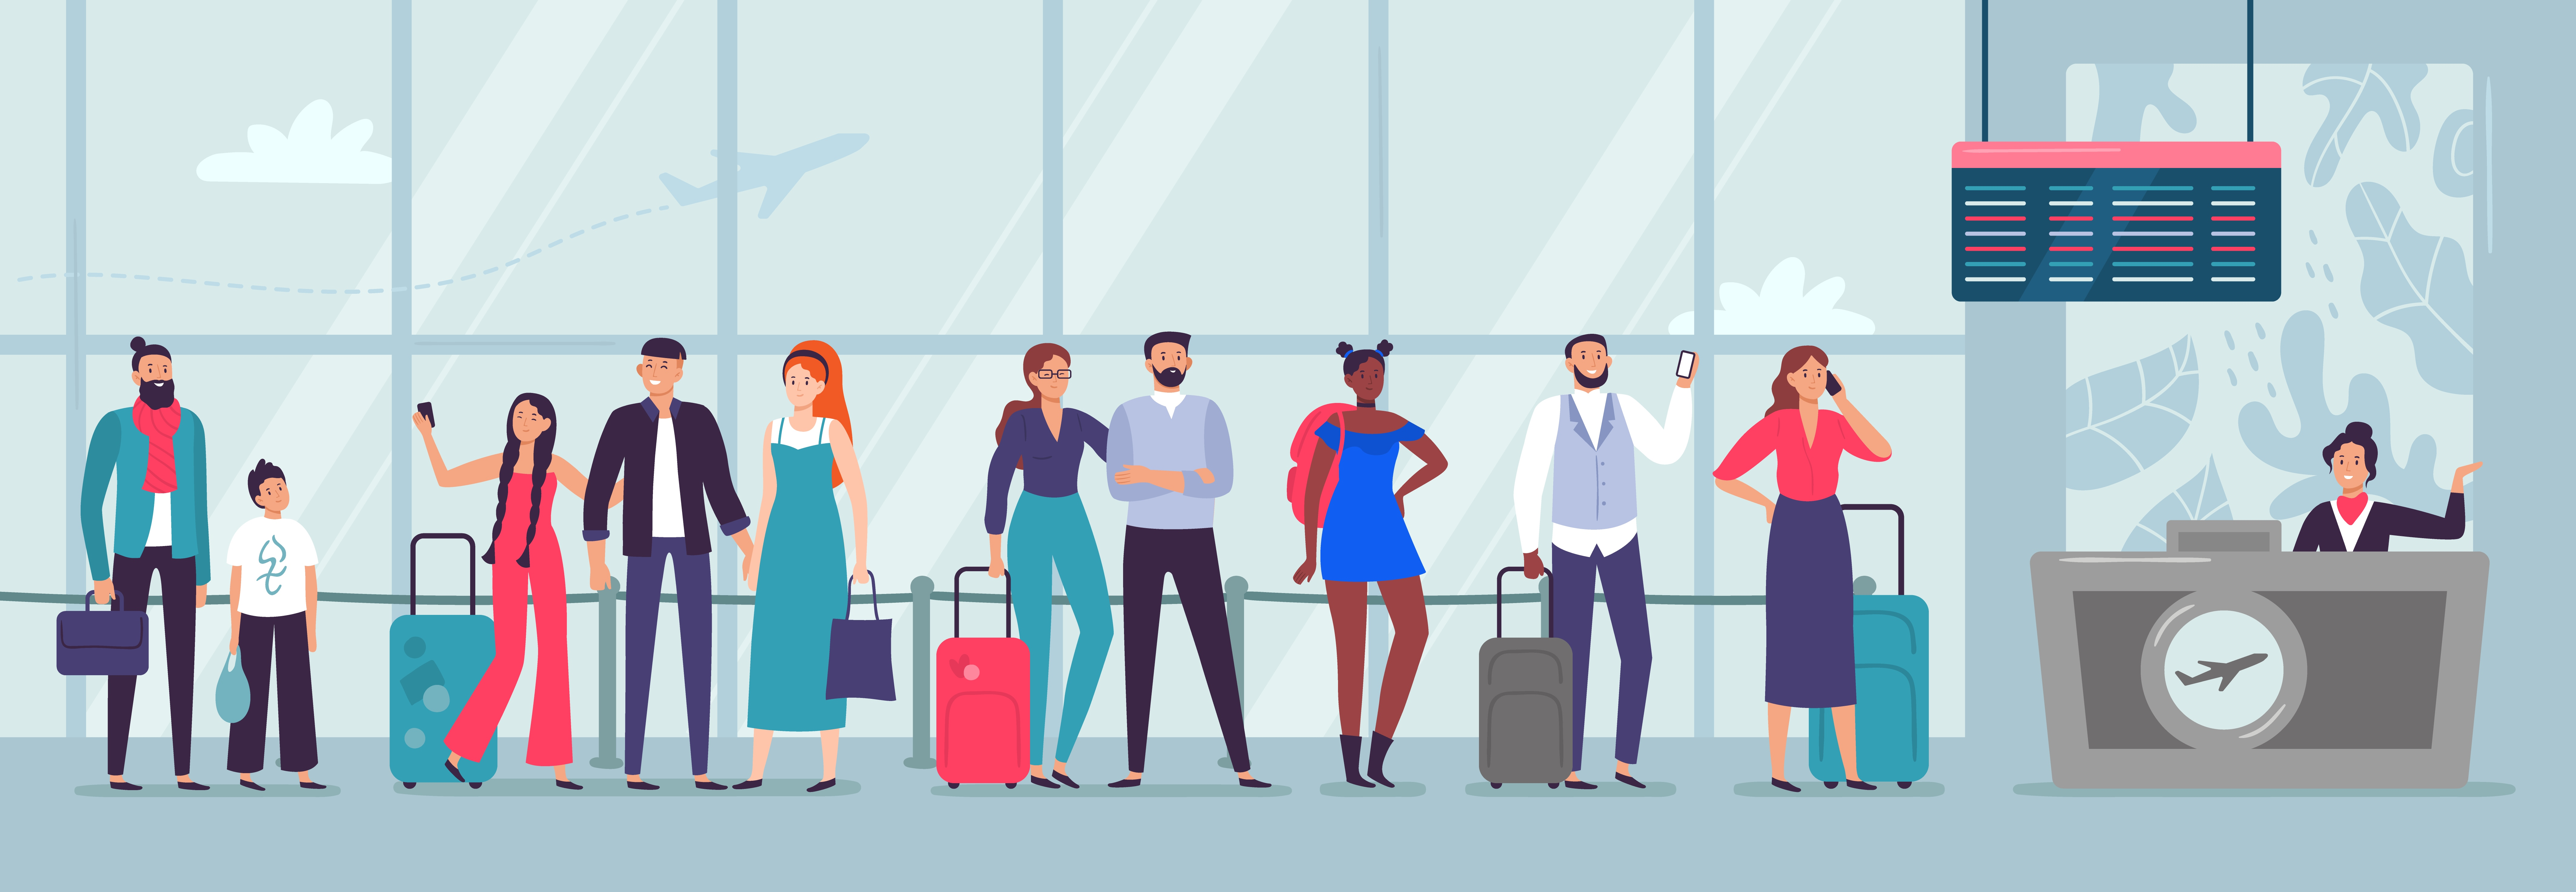

<p align="justify"><b>Research Question:</b> To analyse the delays in airports and to classify them into categories (E.g: low-delay vs moderate delay vs high delay) based on delay metrics by using advanced machine learning techniques. Also, suggesting some airport-specific improvements by considering delay metrics and airport reviews to minimize the delay.</p>

<h1>Introduction</h1>
<p>In order to categorise airports based on delay metrics and suggest airport specific recommendations, following advanced ML models were used,</p>

<ul>
  <li>SVM</li>
  <li>Random Forest</li>
  <li>Gradient Boosting and XGB</li>
  <li>K-Means Clustering</li>
  <li>Natural Language Processing</li>
  <li>Dynamic Random Forest</li>
</ul>

<p><strong>Dynamic Random Forest</strong> is a novel approach that we had tried, which is based on Random Forest but focuses more on important features by using dynamic weights.</p>


# Reading Datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, silhouette_score

pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

In [ ]:
airport_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ML/consolidated_airline_delay_all_columns.xlsx')
airport_df.head()

year  month                     airport_name  arr_flights  arr_del15  \
0  2013      8  Aberdeen, SD: Aberdeen Regional           62          5   
1  2013      9  Aberdeen, SD: Aberdeen Regional           60          3   
2  2013     10  Aberdeen, SD: Aberdeen Regional           70          4   
3  2013     11  Aberdeen, SD: Aberdeen Regional           67          5   
4  2013     12  Aberdeen, SD: Aberdeen Regional           62         24   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  \
0        3.74        0.00    0.28          0.0              0.98   
1        1.00        0.83    1.18          0.0              0.00   
2        2.93        0.00    1.07          0.0              0.00   
3        3.05        0.00    1.88          0.0              0.07   
4        4.11        0.00   12.86          0.0              7.04   

   arr_cancelled  arr_diverted  arr_delay  carrier_delay  weather_delay  \
0              0             0        256            229              0   
1              0             0        128             66             33   
2              0             0        193            173              0   
3              1             0        244            201              0   
4              0             0       1313            282              0   

   nas_delay  security_delay  late_aircraft_delay  
0          8               0                   19  
1         29               0                    0  
2         20               0                    0  
3         38               0                    5  
4        424               0                  607

In [ ]:
weather_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/Weather_FULL.csv')
weather_df.head()

year  month                     airport_name  Avg. Temperature  \
0  2013      8  Aberdeen, SD: Aberdeen Regional             24.63   
1  2013      9  Aberdeen, SD: Aberdeen Regional             23.11   
2  2013     10  Aberdeen, SD: Aberdeen Regional             17.75   
3  2013     11  Aberdeen, SD: Aberdeen Regional             10.19   
4  2013     12  Aberdeen, SD: Aberdeen Regional              8.84   

   Avg. Dew Point  Avg. Percipitation  Avg. Snow Depth  Avg. Wind Speed  \
0           20.42                 0.0              0.0            10.65   
1           17.04                 0.0              0.0            11.23   
2           11.69                 0.0              0.0             9.32   
3            1.42                 0.0              0.0            14.45   
4            3.42                 0.0              0.0            12.54   

   Avg. Gust Wind  
0            1.59  
1            1.30  
2            1.51  
3            5.26  
4            4.09

In [ ]:
full_df = pd.merge(airport_df,weather_df,on = ['year','month','airport_name'],how = 'inner')
full_df.head()

year  month                     airport_name  arr_flights  arr_del15  \
0  2013      8  Aberdeen, SD: Aberdeen Regional           62          5   
1  2013      9  Aberdeen, SD: Aberdeen Regional           60          3   
2  2013     10  Aberdeen, SD: Aberdeen Regional           70          4   
3  2013     11  Aberdeen, SD: Aberdeen Regional           67          5   
4  2013     12  Aberdeen, SD: Aberdeen Regional           62         24   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  ...  \
0        3.74        0.00    0.28          0.0              0.98  ...   
1        1.00        0.83    1.18          0.0              0.00  ...   
2        2.93        0.00    1.07          0.0              0.00  ...   
3        3.05        0.00    1.88          0.0              0.07  ...   
4        4.11        0.00   12.86          0.0              7.04  ...   

   weather_delay  nas_delay  security_delay  late_aircraft_delay  \
0              0          8               0                   19   
1             33         29               0                    0   
2              0         20               0                    0   
3              0         38               0                    5   
4              0        424               0                  607   

   Avg. Temperature  Avg. Dew Point  Avg. Percipitation  Avg. Snow Depth  \
0             24.63           20.42                 0.0              0.0   
1             23.11           17.04                 0.0              0.0   
2             17.75           11.69                 0.0              0.0   
3             10.19            1.42                 0.0              0.0   
4              8.84            3.42                 0.0              0.0   

   Avg. Wind Speed  Avg. Gust Wind  
0            10.65            1.59  
1            11.23            1.30  
2             9.32            1.51  
3            14.45            5.26  
4            12.54            4.09  

[5 rows x 24 columns]

# Exploratory Data Analysis

In [ ]:
full_df.columns

Index(['year', 'month', 'airport_name', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'Avg. Temperature', 'Avg. Dew Point', 'Avg. Percipitation',
       'Avg. Snow Depth', 'Avg. Wind Speed', 'Avg. Gust Wind'],
      dtype='object')

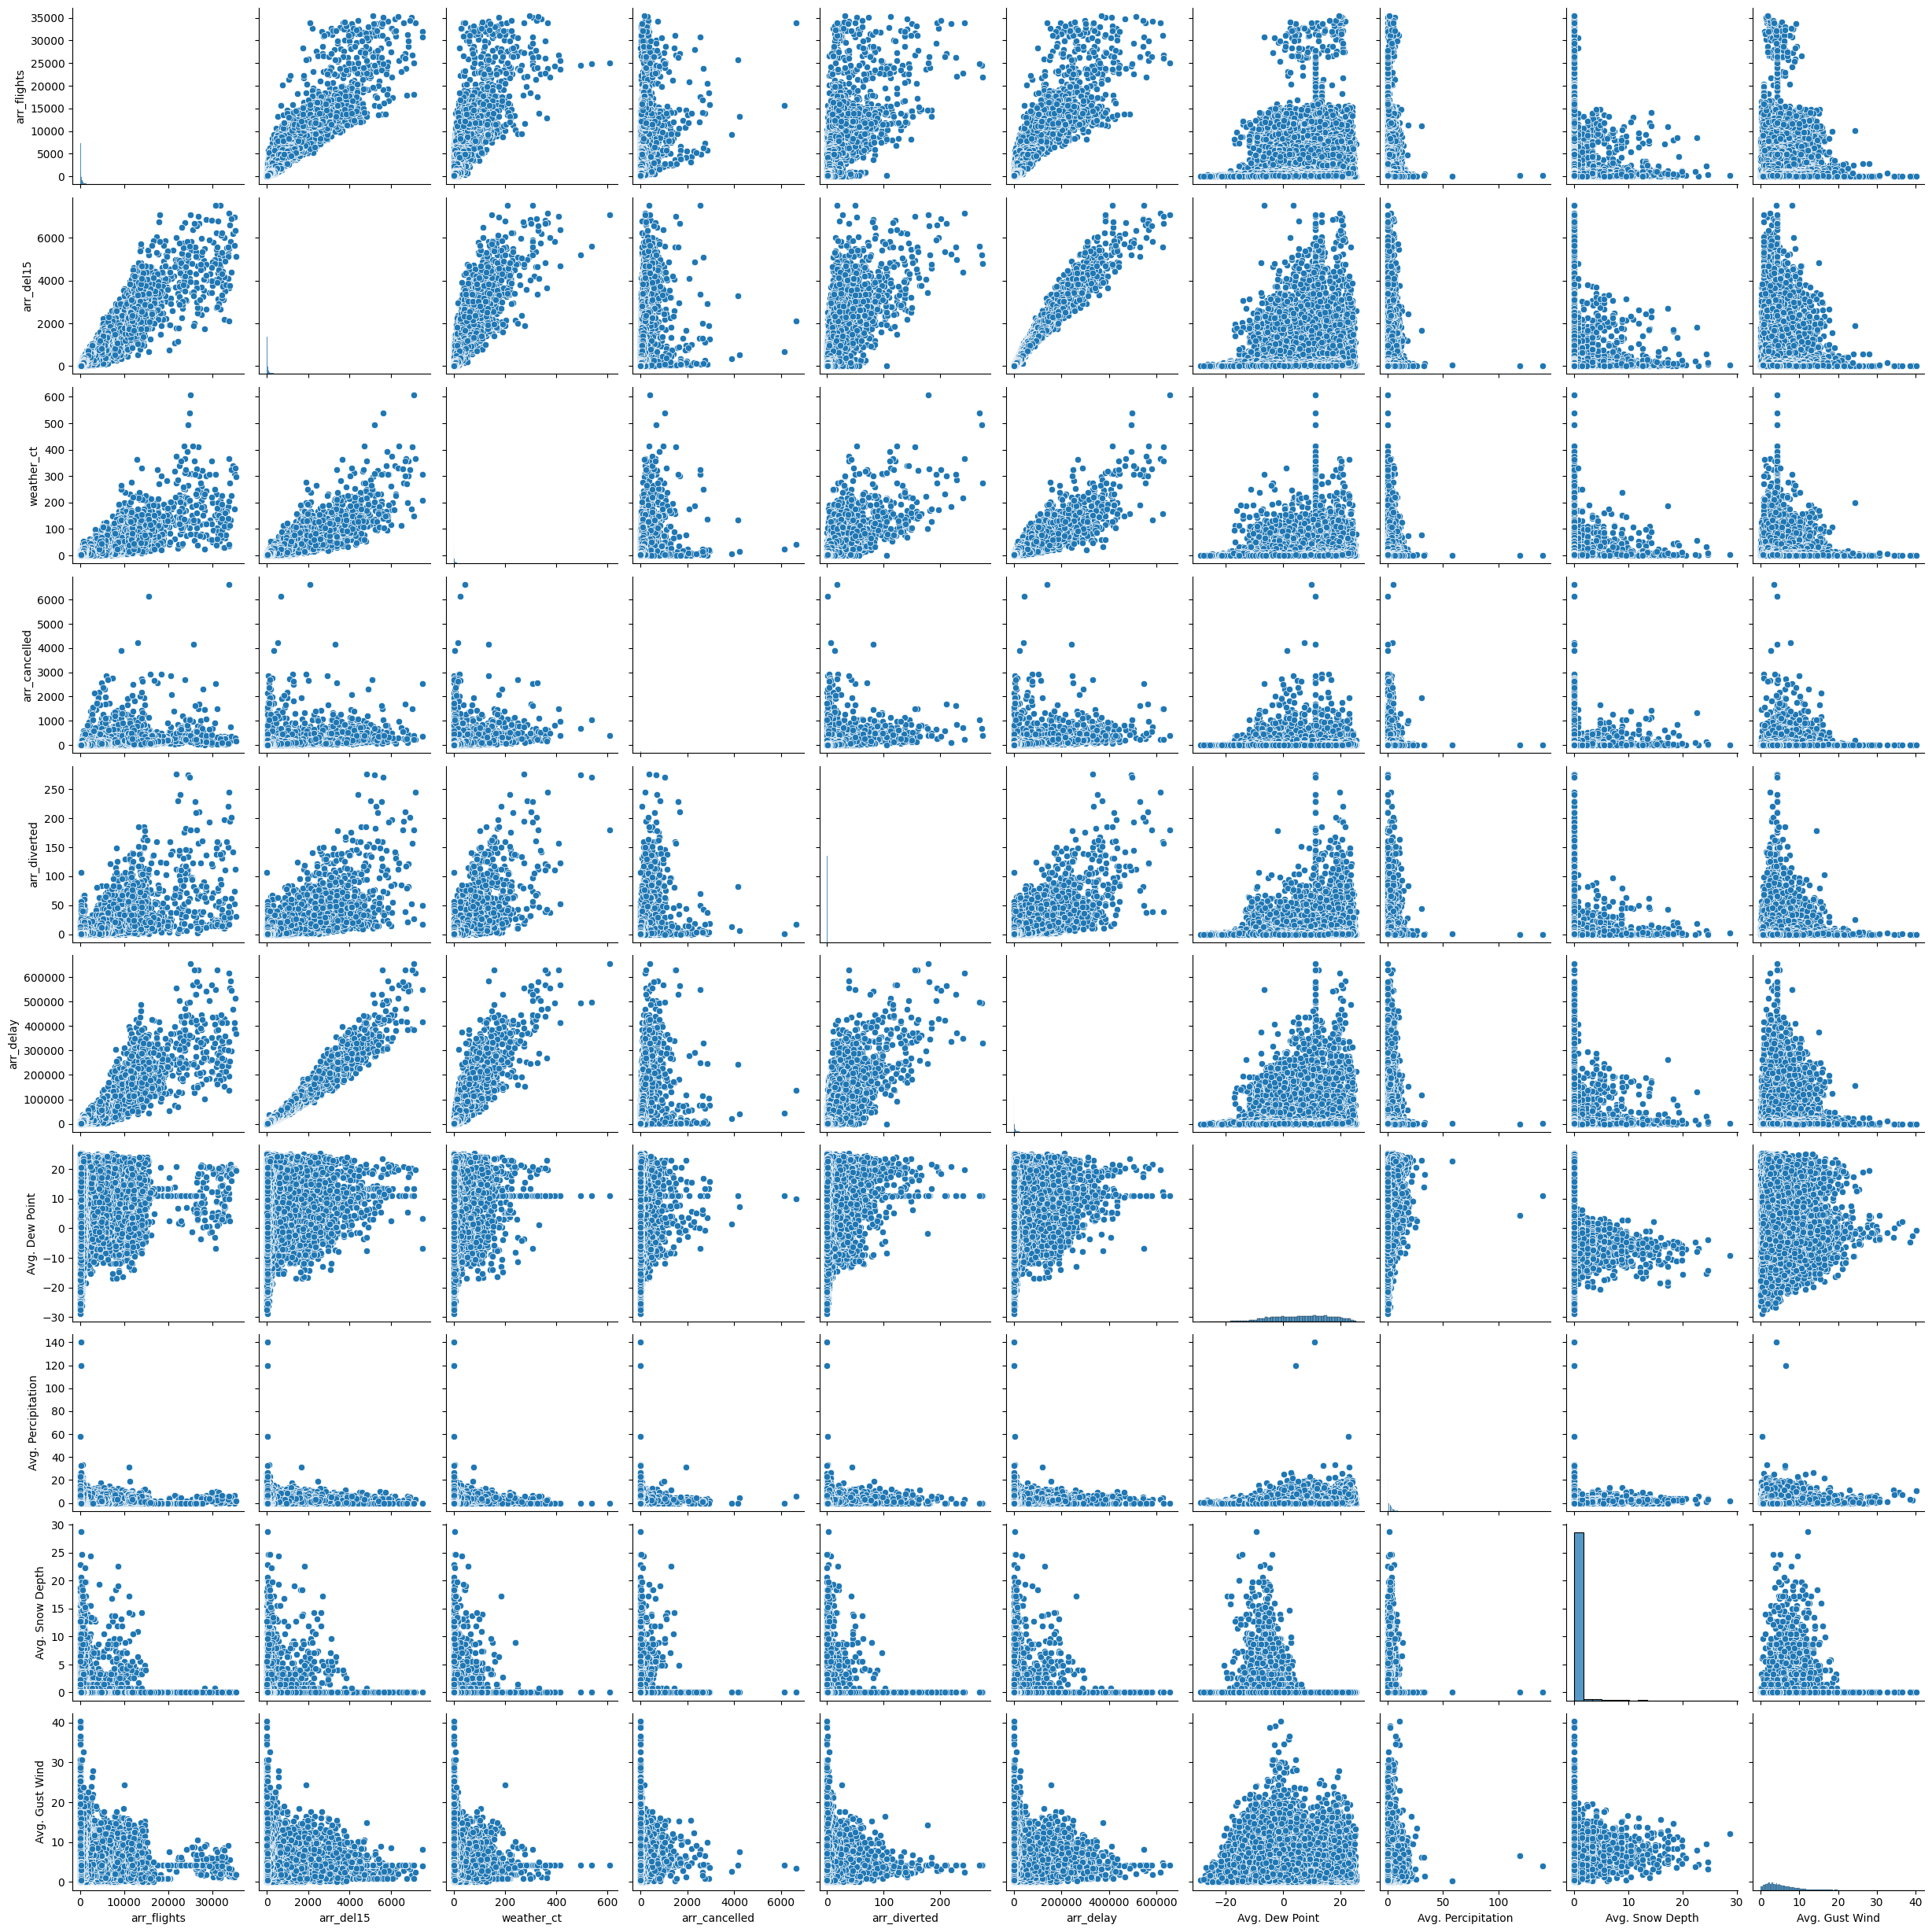

In [ ]:
eda_df = full_df.drop(columns=['year','month','airport_name','carrier_ct', 'nas_ct', 'security_ct', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'late_aircraft_ct','Avg. Temperature','Avg. Wind Speed'])
sns.pairplot(eda_df)
plt.show()

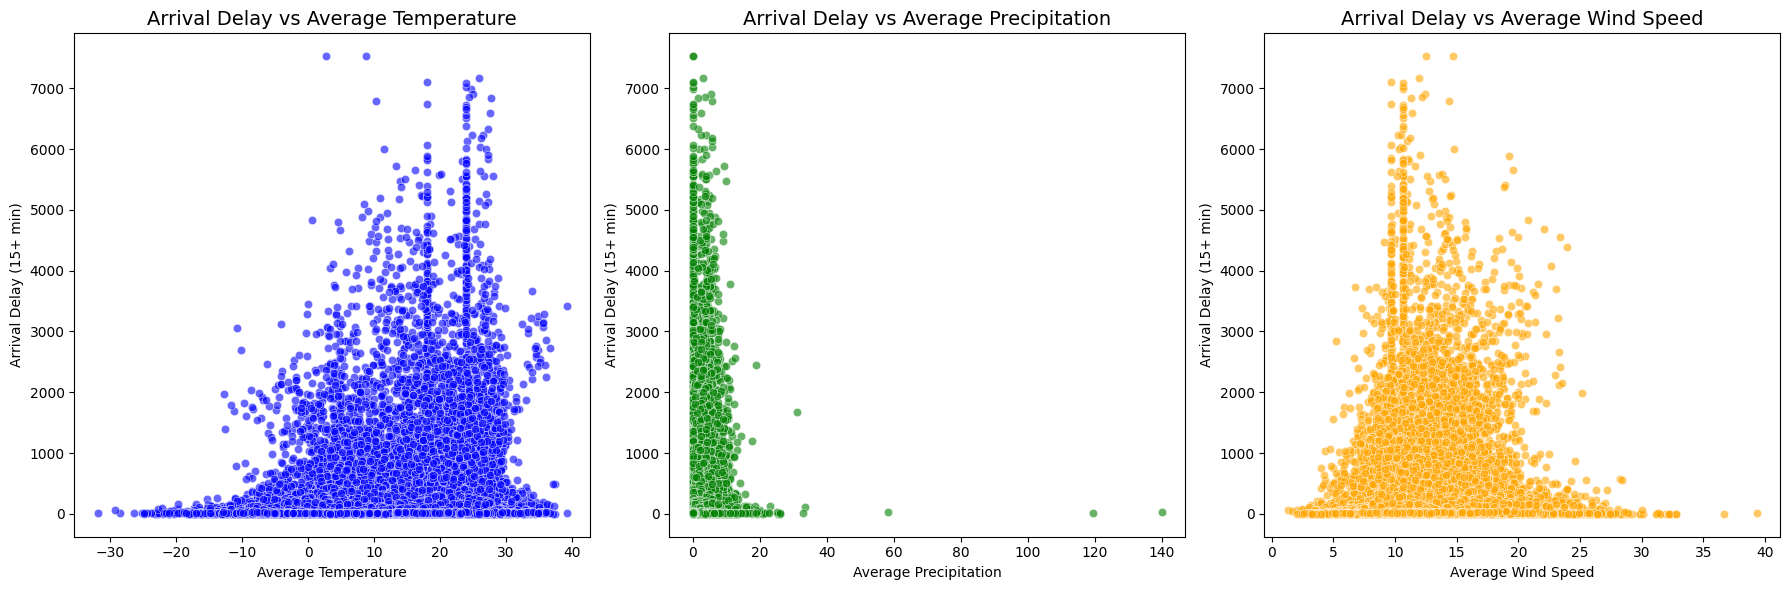

In [ ]:
plt.figure(figsize=(18, 6))

# Arrival delay vs. Average Temperature
plt.subplot(1, 3, 1)
sns.scatterplot(data=full_df, x='Avg. Temperature', y='arr_del15', alpha=0.6, color="blue")
plt.title("Arrival Delay vs Average Temperature", fontsize=14)
plt.xlabel("Average Temperature")
plt.ylabel("Arrival Delay (15+ min)")

# Arrival delay vs. Average Precipitation
plt.subplot(1, 3, 2)
sns.scatterplot(data=full_df, x='Avg. Percipitation', y='arr_del15', alpha=0.6, color="green")
plt.title("Arrival Delay vs Average Precipitation", fontsize=14)
plt.xlabel("Average Precipitation")
plt.ylabel("Arrival Delay (15+ min)")

# Arrival delay vs. Average Wind Speed
plt.subplot(1, 3, 3)
sns.scatterplot(data=full_df, x='Avg. Wind Speed', y='arr_del15', alpha=0.6, color="orange")
plt.title("Arrival Delay vs Average Wind Speed", fontsize=14)
plt.xlabel("Average Wind Speed")
plt.ylabel("Arrival Delay (15+ min)")

plt.tight_layout()
plt.show()

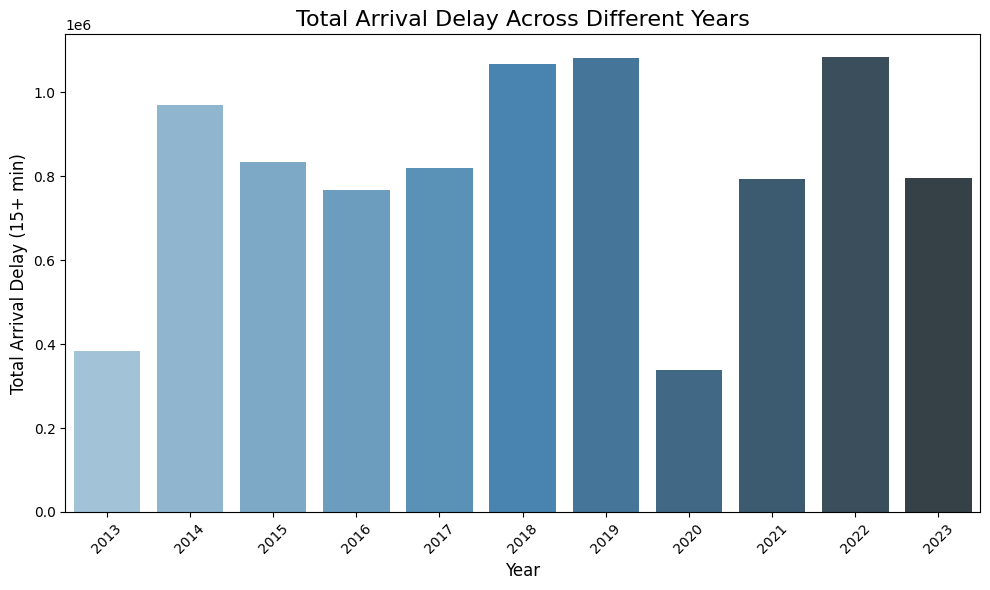

In [ ]:
yearly_delays = full_df.groupby('year')['arr_del15'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=yearly_delays, x='year', y='arr_del15', palette="Blues_d")
plt.title("Total Arrival Delay Across Different Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Arrival Delay (15+ min)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Pre-Processing

## Analysing Dataset

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34391 entries, 0 to 34390
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 34391 non-null  int64  
 1   month                34391 non-null  int64  
 2   airport_name         34391 non-null  object 
 3   arr_flights          34391 non-null  int64  
 4   arr_del15            34391 non-null  int64  
 5   carrier_ct           34391 non-null  float64
 6   weather_ct           34391 non-null  float64
 7   nas_ct               34391 non-null  float64
 8   security_ct          34391 non-null  float64
 9   late_aircraft_ct     34391 non-null  float64
 10  arr_cancelled        34391 non-null  int64  
 11  arr_diverted         34391 non-null  int64  
 12  arr_delay            34391 non-null  int64  
 13  carrier_delay        34391 non-null  int64  
 14  weather_delay        34391 non-null  int64  
 15  nas_delay            34391 non-null 

In [ ]:
full_df.isnull().sum()

year                     0
month                    0
airport_name             0
arr_flights              0
arr_del15                0
carrier_ct               0
weather_ct               0
nas_ct                   0
security_ct              0
late_aircraft_ct         0
arr_cancelled            0
arr_diverted             0
arr_delay                0
carrier_delay            0
weather_delay            0
nas_delay                0
security_delay           0
late_aircraft_delay      0
Avg. Temperature       111
Avg. Dew Point         111
Avg. Percipitation     111
Avg. Snow Depth        111
Avg. Wind Speed        111
Avg. Gust Wind         111
dtype: int64

In [ ]:
ag = full_df[full_df['airport_name'] == 'Aguadilla, PR: Rafael Hernandez']
ag

year  month                     airport_name  arr_flights  arr_del15  \
349  2013      8  Aguadilla, PR: Rafael Hernandez          121         21   
350  2013      9  Aguadilla, PR: Rafael Hernandez           70          8   
351  2013     10  Aguadilla, PR: Rafael Hernandez           68          9   
352  2013     11  Aguadilla, PR: Rafael Hernandez           85         13   
353  2013     12  Aguadilla, PR: Rafael Hernandez          116         42   
..    ...    ...                              ...          ...        ...   
455  2023      4  Aguadilla, PR: Rafael Hernandez          204         87   
456  2023      5  Aguadilla, PR: Rafael Hernandez          251        100   
457  2023      6  Aguadilla, PR: Rafael Hernandez          250        130   
458  2023      7  Aguadilla, PR: Rafael Hernandez          304        167   
459  2023      8  Aguadilla, PR: Rafael Hernandez          310        141   

     carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  ...  \
349        6.45        0.06    4.85         0.00              9.63  ...   
350        3.94        0.88    3.06         0.00              0.12  ...   
351        4.30        0.00    4.70         0.00              0.00  ...   
352        7.64        0.00    4.89         0.00              0.47  ...   
353       19.97        0.62   15.29         0.00              6.12  ...   
..          ...         ...     ...          ...               ...  ...   
455       35.87        5.88   23.42         1.55             20.27  ...   
456       47.82        8.15   20.21         0.00             23.82  ...   
457       56.10       11.32   26.79         2.35             33.44  ...   
458       67.41       13.66   22.11         1.27             62.55  ...   
459       60.89        5.86   31.02         1.00             42.24  ...   

     weather_delay  nas_delay  security_delay  late_aircraft_delay  \
349              8        171               0                  550   
350             52        142               0                    7   
351              0        102               0                    0   
352              0        112               0                   13   
353             38        407               0                  283   
..             ...        ...             ...                  ...   
455            492       1127              47                 2827   
456            520        933               0                 2003   
457           1286       1604             136                 3416   
458           1609       1933             136                 7904   
459            270       1370              16                 4056   

     Avg. Temperature  Avg. Dew Point  Avg. Percipitation  Avg. Snow Depth  \
349               NaN             NaN                 NaN              NaN   
350               NaN             NaN                 NaN              NaN   
351               NaN             NaN                 NaN              NaN   
352               NaN             NaN                 NaN              NaN   
353               NaN             NaN                 NaN              NaN   
..                ...             ...                 ...              ...   
455               NaN             NaN                 NaN              NaN   
456               NaN             NaN                 NaN              NaN   
457               NaN             NaN                 NaN              NaN   
458               NaN             NaN                 NaN              NaN   
459               NaN             NaN                 NaN              NaN   

     Avg. Wind Speed  Avg. Gust Wind  
349              NaN             NaN  
350              NaN             NaN  
351              NaN             NaN  
352              NaN             NaN  
353              NaN             NaN  
..               ...             ...  
455              NaN             NaN  
456              NaN             NaN  
457              NaN             NaN  
458        

Weather details couldn't be found for 'Aguadilla, PR: Rafael Hernandez' Airport since it's outside of US. Hence excluding that airport.

In [ ]:
Final_df = full_df[full_df['airport_name'] != 'Aguadilla, PR: Rafael Hernandez']
Final_df

year  month                            airport_name  arr_flights  \
0      2013      8         Aberdeen, SD: Aberdeen Regional           62   
1      2013      9         Aberdeen, SD: Aberdeen Regional           60   
2      2013     10         Aberdeen, SD: Aberdeen Regional           70   
3      2013     11         Aberdeen, SD: Aberdeen Regional           67   
4      2013     12         Aberdeen, SD: Aberdeen Regional           62   
...     ...    ...                                     ...          ...   
34386  2023      4  Yuma, AZ: Yuma MCAS/Yuma International          120   
34387  2023      5  Yuma, AZ: Yuma MCAS/Yuma International          124   
34388  2023      6  Yuma, AZ: Yuma MCAS/Yuma International          146   
34389  2023      7  Yuma, AZ: Yuma MCAS/Yuma International          146   
34390  2023      8  Yuma, AZ: Yuma MCAS/Yuma International          171   

       arr_del15  carrier_ct  weather_ct  nas_ct  security_ct  \
0              5        3.74        0.00    0.28          0.0   
1              3        1.00        0.83    1.18          0.0   
2              4        2.93        0.00    1.07          0.0   
3              5        3.05        0.00    1.88          0.0   
4             24        4.11        0.00   12.86          0.0   
...          ...         ...         ...     ...          ...   
34386         16        9.68        0.00    4.35          0.0   
34387          5        2.27        1.00    0.84          0.0   
34388         26       16.74        4.00    1.27          0.0   
34389         23       10.28        0.93    6.60          0.0   
34390         22       15.22        2.00    0.00          0.0   

       late_aircraft_ct  ...  weather_delay  nas_delay  security_delay  \
0                  0.98  ...              0          8               0   
1                  0.00  ...             33         29               0   
2                  0.00  ...              0         20               0   
3                  0.07  ...              0         38               0   
4                  7.04  ...              0        424               0   
...                 ...  ...            ...        ...             ...   
34386              1.97  ...              0         96               0   
34387              0.90  ...             38         14               0   
34388              3.99  ...            238         27               0   
34389              5.20  ...            671        199               0   
34390              4.78  ...            140          0               0   

       late_aircraft_delay  Avg. Temperature  Avg. Dew Point  \
0                       19             24.63           20.42   
1                        0             23.11           17.04   
2                        0             17.75           11.69   
3                        5             10.19            1.42   
4                      607              8.84            3.42   
...                    ...               ...             ...   
34386                  146             23.16            0.26   
34387                   26             25.97            5.20   
34388                  266             29.39            4.38   
34389                  338             36.11           14.21   
34390                  197             34.84           15.66   

       Avg. Percipitation  Avg. Snow Depth  Avg. Wind Speed  Avg. Gust Wind  
0                     0.0              0.0            10.65            1.59  
1                     0.0              0.0            11.23            1.30  
2                     0.0              0.0             9.32            1.51  
3                     0.0              0.0            14.45            5.26  
4                     0.0              0.0            12.54            4.09  
...                   ...              ...              ...             ...  
34386                 0.0              0.0            10.15            3.72  
34387                 0.0              0.0 

In [ ]:
Final_df.isnull().sum()

year                   0
month                  0
airport_name           0
arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
Avg. Temperature       0
Avg. Dew Point         0
Avg. Percipitation     0
Avg. Snow Depth        0
Avg. Wind Speed        0
Avg. Gust Wind         0
dtype: int64

In [ ]:
Final_df

year  month                            airport_name  arr_flights  \
0      2013      8         Aberdeen, SD: Aberdeen Regional           62   
1      2013      9         Aberdeen, SD: Aberdeen Regional           60   
2      2013     10         Aberdeen, SD: Aberdeen Regional           70   
3      2013     11         Aberdeen, SD: Aberdeen Regional           67   
4      2013     12         Aberdeen, SD: Aberdeen Regional           62   
...     ...    ...                                     ...          ...   
34386  2023      4  Yuma, AZ: Yuma MCAS/Yuma International          120   
34387  2023      5  Yuma, AZ: Yuma MCAS/Yuma International          124   
34388  2023      6  Yuma, AZ: Yuma MCAS/Yuma International          146   
34389  2023      7  Yuma, AZ: Yuma MCAS/Yuma International          146   
34390  2023      8  Yuma, AZ: Yuma MCAS/Yuma International          171   

       arr_del15  carrier_ct  weather_ct  nas_ct  security_ct  \
0              5        3.74        0.00    0.28          0.0   
1              3        1.00        0.83    1.18          0.0   
2              4        2.93        0.00    1.07          0.0   
3              5        3.05        0.00    1.88          0.0   
4             24        4.11        0.00   12.86          0.0   
...          ...         ...         ...     ...          ...   
34386         16        9.68        0.00    4.35          0.0   
34387          5        2.27        1.00    0.84          0.0   
34388         26       16.74        4.00    1.27          0.0   
34389         23       10.28        0.93    6.60          0.0   
34390         22       15.22        2.00    0.00          0.0   

       late_aircraft_ct  ...  weather_delay  nas_delay  security_delay  \
0                  0.98  ...              0          8               0   
1                  0.00  ...             33         29               0   
2                  0.00  ...              0         20               0   
3                  0.07  ...              0         38               0   
4                  7.04  ...              0        424               0   
...                 ...  ...            ...        ...             ...   
34386              1.97  ...              0         96               0   
34387              0.90  ...             38         14               0   
34388              3.99  ...            238         27               0   
34389              5.20  ...            671        199               0   
34390              4.78  ...            140          0               0   

       late_aircraft_delay  Avg. Temperature  Avg. Dew Point  \
0                       19             24.63           20.42   
1                        0             23.11           17.04   
2                        0             17.75           11.69   
3                        5             10.19            1.42   
4                      607              8.84            3.42   
...                    ...               ...             ...   
34386                  146             23.16            0.26   
34387                   26             25.97            5.20   
34388                  266             29.39            4.38   
34389                  338             36.11           14.21   
34390                  197             34.84           15.66   

       Avg. Percipitation  Avg. Snow Depth  Avg. Wind Speed  Avg. Gust Wind  
0                     0.0              0.0            10.65            1.59  
1                     0.0              0.0            11.23            1.30  
2                     0.0              0.0             9.32            1.51  
3                     0.0              0.0            14.45            5.26  
4                     0.0              0.0            12.54            4.09  
...                   ...              ...              ...             ...  
34386                 0.0              0.0            10.15            3.72  
34387                 0.0              0.0 

In [ ]:
Final_df.columns

Index(['year', 'month', 'airport_name', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'Avg. Temperature', 'Avg. Dew Point', 'Avg. Percipitation',
       'Avg. Snow Depth', 'Avg. Wind Speed', 'Avg. Gust Wind'],
      dtype='object')

## Feature Engineering

Extracting a new feature ‘**Delay percent**’ for each airport based on the number of flights arrived and total flights that are delayed.

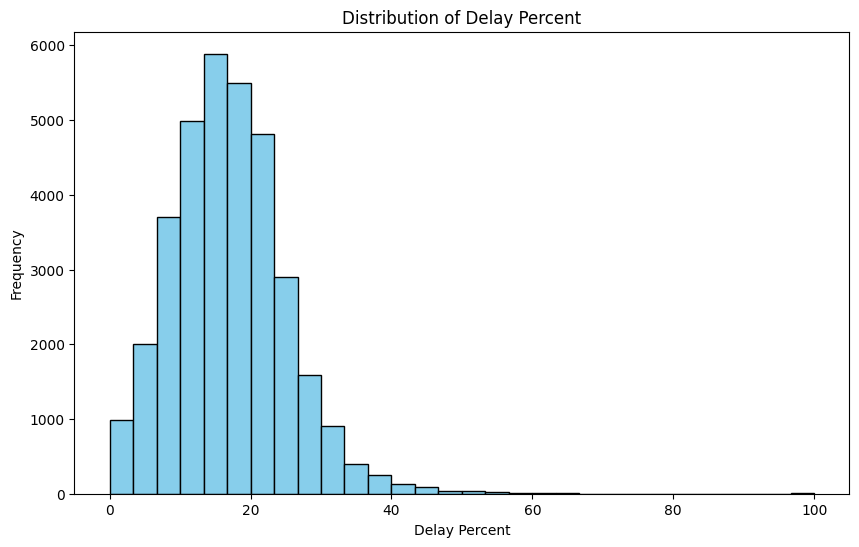

Mean Delay : 16.95%
Standard Deviation : 8.28%


In [ ]:
Final_df['delay_percent'] =  (Final_df['arr_del15'] / Final_df['arr_flights']) * 100
Final_df.fillna(0, inplace=True)

plt.figure(figsize=(10, 6))
plt.hist(Final_df['delay_percent'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Delay Percent')
plt.xlabel('Delay Percent')
plt.ylabel('Frequency')
plt.show()

mean_delay = Final_df['delay_percent'].mean()
std_delay = Final_df['delay_percent'].std()
print(f"Mean Delay : {round(mean_delay,2)}%")
print(f"Standard Deviation : {round(std_delay,2)}%")

Creating ’**Arrival delay hours**’ for converting the delay to hours, since unit of ‘**Arrival delay**’ is minutes.

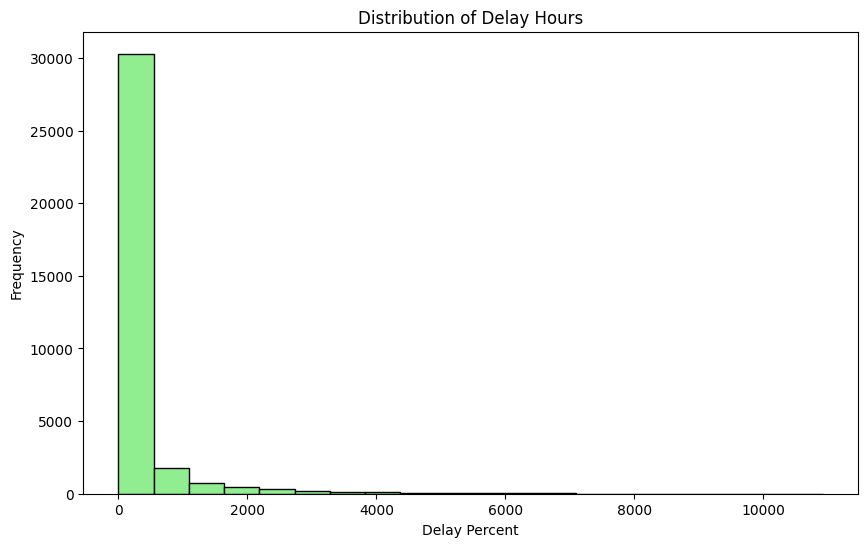

Mean Delay : 275.47 Hours
Standard Deviation : 742.71 Hours


In [ ]:
# Arrival delay in Hours

Final_df['arr_delay_hours'] = (Final_df['arr_delay'] / 60)
Final_df.head()

plt.figure(figsize=(10, 6))
plt.hist(Final_df['arr_delay_hours'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Delay Hours')
plt.xlabel('Delay Percent')
plt.ylabel('Frequency')
plt.show()

mean_delay = Final_df['arr_delay_hours'].mean()
std_delay = Final_df['arr_delay_hours'].std()
print(f"Mean Delay : {round(mean_delay,2)} Hours")
print(f"Standard Deviation : {round(std_delay,2)} Hours")

## Feature Scaling & Target Variable Creation

In [ ]:
data = Final_df.copy()
data

year  month                            airport_name  arr_flights  \
0      2013      8         Aberdeen, SD: Aberdeen Regional           62   
1      2013      9         Aberdeen, SD: Aberdeen Regional           60   
2      2013     10         Aberdeen, SD: Aberdeen Regional           70   
3      2013     11         Aberdeen, SD: Aberdeen Regional           67   
4      2013     12         Aberdeen, SD: Aberdeen Regional           62   
...     ...    ...                                     ...          ...   
34386  2023      4  Yuma, AZ: Yuma MCAS/Yuma International          120   
34387  2023      5  Yuma, AZ: Yuma MCAS/Yuma International          124   
34388  2023      6  Yuma, AZ: Yuma MCAS/Yuma International          146   
34389  2023      7  Yuma, AZ: Yuma MCAS/Yuma International          146   
34390  2023      8  Yuma, AZ: Yuma MCAS/Yuma International          171   

       arr_del15  carrier_ct  weather_ct  nas_ct  security_ct  \
0              5        3.74        0.00    0.28          0.0   
1              3        1.00        0.83    1.18          0.0   
2              4        2.93        0.00    1.07          0.0   
3              5        3.05        0.00    1.88          0.0   
4             24        4.11        0.00   12.86          0.0   
...          ...         ...         ...     ...          ...   
34386         16        9.68        0.00    4.35          0.0   
34387          5        2.27        1.00    0.84          0.0   
34388         26       16.74        4.00    1.27          0.0   
34389         23       10.28        0.93    6.60          0.0   
34390         22       15.22        2.00    0.00          0.0   

       late_aircraft_ct  ...  security_delay  late_aircraft_delay  \
0                  0.98  ...               0                   19   
1                  0.00  ...               0                    0   
2                  0.00  ...               0                    0   
3                  0.07  ...               0                    5   
4                  7.04  ...               0                  607   
...                 ...  ...             ...                  ...   
34386              1.97  ...               0                  146   
34387              0.90  ...               0                   26   
34388              3.99  ...               0                  266   
34389              5.20  ...               0                  338   
34390              4.78  ...               0                  197   

       Avg. Temperature  Avg. Dew Point  Avg. Percipitation  Avg. Snow Depth  \
0                 24.63           20.42                 0.0              0.0   
1                 23.11           17.04                 0.0              0.0   
2                 17.75           11.69                 0.0              0.0   
3                 10.19            1.42                 0.0              0.0   
4                  8.84            3.42                 0.0              0.0   
...                 ...             ...                 ...              ...   
34386             23.16            0.26                 0.0              0.0   
34387             25.97            5.20                 0.0              0.0   
34388             29.39            4.38                 0.0              0.0   
34389             36.11           14.21                 0.0              0.0   
34390             34.84           15.66                 0.0              0.0   

       Avg. Wind Speed  Avg. Gust Wind  delay_percent  arr_delay_hours  
0                10.65            1.59       8.064516         4.266667  
1                11.23            1.30       5.000000         2.133333  
2                 9.32            1.51       5.714286         3.216667  
3                14.45            5.26       7.462687         4.066667  
4                12.54            4.09      38.709677        21.883333  
...                ...             ...            ...              ...  
34386            10.15  

In [ ]:
weather_features = ['Avg. Temperature', 'Avg. Dew Point', 'Avg. Percipitation', 'Avg. Snow Depth', 'Avg. Wind Speed', 'Avg. Gust Wind']
airport_delay_features = [col for col in data.columns if col not in weather_features + ['delay_category', 'airport_name']]

scaler_weather = MinMaxScaler()
data_normalized_weather = scaler_weather.fit_transform(data[weather_features])
data[weather_features] = data_normalized_weather

data['weather_delay_score_normalized'] = data[weather_features].mean(axis=1)

scaler_airport_delay = MinMaxScaler()
data_normalized_airport = scaler_airport_delay.fit_transform(data[airport_delay_features])
data[airport_delay_features] = data_normalized_airport

data['airport_delay_score_normalized'] = data[airport_delay_features].mean(axis=1)

data['composite_delay_score_normalized'] = data[['weather_delay_score_normalized', 'airport_delay_score_normalized']].mean(axis=1)

low_threshold_normalized = data['composite_delay_score_normalized'].quantile(0.33)
high_threshold_normalized = data['composite_delay_score_normalized'].quantile(0.67)

def categorize_normalized_delay(score):
    if score <= low_threshold_normalized:
        return 'Low Delay'
    elif score <= high_threshold_normalized:
        return 'Moderate Delay'
    else:
        return 'High Delay'

data['delay_category'] = data['composite_delay_score_normalized'].apply(categorize_normalized_delay)

In [ ]:
data['delay_category'].value_counts()

delay_category
Moderate Delay    11654
Low Delay         11313
High Delay        11313
Name: count, dtype: int64

In [ ]:
data['year'].value_counts()

year
0.8    3734
0.9    3705
0.7    3622
0.6    3602
0.5    3551
0.2    3186
0.1    3139
0.3    3086
0.4    3016
1.0    2350
0.0    1289
Name: count, dtype: int64

In [ ]:
data = data.drop(columns=['year'])
data

month                            airport_name  arr_flights  \
0      0.636364         Aberdeen, SD: Aberdeen Regional     0.001750   
1      0.727273         Aberdeen, SD: Aberdeen Regional     0.001693   
2      0.818182         Aberdeen, SD: Aberdeen Regional     0.001976   
3      0.909091         Aberdeen, SD: Aberdeen Regional     0.001891   
4      1.000000         Aberdeen, SD: Aberdeen Regional     0.001750   
...         ...                                     ...          ...   
34386  0.272727  Yuma, AZ: Yuma MCAS/Yuma International     0.003387   
34387  0.363636  Yuma, AZ: Yuma MCAS/Yuma International     0.003499   
34388  0.454545  Yuma, AZ: Yuma MCAS/Yuma International     0.004120   
34389  0.545455  Yuma, AZ: Yuma MCAS/Yuma International     0.004120   
34390  0.636364  Yuma, AZ: Yuma MCAS/Yuma International     0.004826   

       arr_del15  carrier_ct  weather_ct    nas_ct  security_ct  \
0       0.000664    0.001645    0.000000  0.000064          0.0   
1       0.000399    0.000440    0.001366  0.000269          0.0   
2       0.000531    0.001289    0.000000  0.000244          0.0   
3       0.000664    0.001342    0.000000  0.000428          0.0   
4       0.003188    0.001808    0.000000  0.002927          0.0   
...          ...         ...         ...       ...          ...   
34386   0.002125    0.004258    0.000000  0.000990          0.0   
34387   0.000664    0.000999    0.001646  0.000191          0.0   
34388   0.003454    0.007364    0.006583  0.000289          0.0   
34389   0.003055    0.004522    0.001530  0.001502          0.0   
34390   0.002922    0.006695    0.003291  0.000000          0.0   

       late_aircraft_ct  arr_cancelled  ...  Avg. Percipitation  \
0              0.000314       0.000000  ...                 0.0   
1              0.000000       0.000000  ...                 0.0   
2              0.000000       0.000000  ...                 0.0   
3              0.000022       0.000151  ...                 0.0   
4              0.002256       0.000000  ...                 0.0   
...                 ...            ...  ...                 ...   
34386          0.000631       0.000151  ...                 0.0   
34387          0.000288       0.000000  ...                 0.0   
34388          0.001279       0.000301  ...                 0.0   
34389          0.001666       0.000000  ...                 0.0   
34390          0.001532       0.000603  ...                 0.0   

       Avg. Snow Depth  Avg. Wind Speed  Avg. Gust Wind  delay_percent  \
0                  0.0         0.245656        0.039454       0.080645   
1                  0.0         0.260927        0.032258       0.050000   
2                  0.0         0.210637        0.037469       0.057143   
3                  0.0         0.345708        0.130521       0.074627   
4                  0.0         0.295419        0.101489       0.387097   
...                ...              ...             ...            ...   
34386              0.0         0.232491        0.092308       0.133333   
34387              0.0         0.302001        0.117866       0.040323   
34388              0.0         0.260927        0.074194       0.178082   
34389              0.0         0.333070        0.108685       0.157534   
34390              0.0         0.306477        0.104963       0.128655   

       arr_delay_hours  weather_delay_score_normalized  \
0             0.000391                        0.331167   
1             0.000195                        0.318568   
2             0.000294                        0.282055   
3             0.000372                        0.270807   
4             0.002003                        0.260563   
...                ...                             ...   
34386         0.001373                        0.272422   
34387         0.000293                        0.310028   
34388         0.001671                        0.301405   
34389         0.002571                        0.365125   
34390   

# Applying ML Models

## Test-Train Split

In [ ]:
single_entry_airports = data.groupby('airport_name').filter(lambda x: len(x) == 1)
multiple_entry_airports = data.groupby('airport_name').filter(lambda x: len(x) > 1)

train_list = []
test_list = [single_entry_airports]

for airport, group_data in multiple_entry_airports.groupby('airport_name'):
    train_data, test_data = train_test_split(group_data, test_size=0.3, random_state=42)
    train_list.append(train_data)
    test_list.append(test_data)

train_data = pd.concat(train_list).reset_index(drop=True)
test_data = pd.concat(test_list).reset_index(drop=True)

X_train = train_data.drop(columns=['weather_delay_score_normalized', 'airport_delay_score_normalized', 'composite_delay_score_normalized', 'delay_category', 'airport_name'])
y_train = train_data['delay_category']
X_test = test_data.drop(columns=['weather_delay_score_normalized', 'airport_delay_score_normalized', 'composite_delay_score_normalized', 'delay_category', 'airport_name'])
y_test = test_data['delay_category']

label_encoders = {}
for column in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    label_encoders[column] = le

target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_svm)

y_pred_labels = target_encoder.inverse_transform(y_pred_svm)

In [ ]:
print("Accurracy: ", {accuracy})
print("SVM Classification Report:")
y_test_labels = target_encoder.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

Accurracy:  {0.8410823170731707}
SVM Classification Report:
                precision    recall  f1-score   support

    High Delay       0.85      0.89      0.87      3349
     Low Delay       0.92      0.87      0.89      3581
Moderate Delay       0.76      0.77      0.77      3566

      accuracy                           0.84     10496
     macro avg       0.84      0.84      0.84     10496
  weighted avg       0.84      0.84      0.84     10496



In [ ]:
test_data['predicted_delay_category_svm'] = y_pred_labels

predictions_by_airport_svm = test_data[['airport_name', 'predicted_delay_category_svm']]
predictions_by_airport_svm_grouped = predictions_by_airport_svm.groupby('airport_name').apply(lambda x: x['predicted_delay_category_svm'].value_counts().idxmax())

print(predictions_by_airport_svm_grouped)

high_delay_airports_svm = predictions_by_airport_svm_grouped[predictions_by_airport_svm_grouped == 'High Delay']

print("\nHigh Delay Airports Predicted:")
print(high_delay_airports_svm)

airport_name
Aberdeen, SD: Aberdeen Regional                        Moderate Delay
Abilene, TX: Abilene Regional                              High Delay
Adak Island, AK: Adak                                      High Delay
Akron, OH: Akron-Canton Regional                       Moderate Delay
Alamosa, CO: San Luis Valley Regional/Bergman Field         Low Delay
                                                            ...      
Wrangell, AK: Wrangell Airport                              Low Delay
Yakima, WA: Yakima Air Terminal/McAllister Field            Low Delay
Yakutat, AK: Yakutat Airport                                Low Delay
Youngstown/Warren, OH: Youngstown-Warren Regional      Moderate Delay
Yuma, AZ: Yuma MCAS/Yuma International                      Low Delay
Length: 348, dtype: object

High Delay Airports Predicted:
airport_name
Abilene, TX: Abilene Regional                               High Delay
Adak Island, AK: Adak                                       High Delay
Ama

## Random Forest

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

y_pred_labels = target_encoder.inverse_transform(y_pred)

# k-fold cross validation
cv_scores_new_target = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy_new_target = np.mean(cv_scores_new_target)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print("Accurracy: ", {accuracy})
print("Cross-Validation Scores: ", {tuple(cv_scores_new_target)})
print("Mean Accuracy: ", {mean_accuracy_new_target})

print("Random Forest Classification Report:")
y_test_labels = target_encoder.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

Accurracy:  {0.8386051829268293}
Cross-Validation Scores:  {(0.8364515450914441, 0.8620979608997267, 0.8515871347487912, 0.8307756989699391, 0.8408326324642557)}
Mean Accuracy:  {0.8443489944348315}
Random Forest Classification Report:
                precision    recall  f1-score   support

    High Delay       0.86      0.88      0.87      3349
     Low Delay       0.90      0.88      0.89      3581
Moderate Delay       0.76      0.76      0.76      3566

      accuracy                           0.84     10496
     macro avg       0.84      0.84      0.84     10496
  weighted avg       0.84      0.84      0.84     10496



In [ ]:
test_data['predicted_delay_category_rf'] = y_pred_labels

predictions_by_airport_rf = test_data[['airport_name', 'predicted_delay_category_rf']]
predictions_by_airport_rf_grouped = predictions_by_airport_rf.groupby('airport_name').apply(lambda x: x['predicted_delay_category_rf'].value_counts().idxmax())

print(predictions_by_airport_rf_grouped)

high_delay_airports_rf = predictions_by_airport_rf_grouped[predictions_by_airport_rf_grouped == 'High Delay']

print("\nHigh Delay Airports Predicted:")
print(high_delay_airports_rf)

airport_name
Aberdeen, SD: Aberdeen Regional                        Moderate Delay
Abilene, TX: Abilene Regional                              High Delay
Adak Island, AK: Adak                                      High Delay
Akron, OH: Akron-Canton Regional                       Moderate Delay
Alamosa, CO: San Luis Valley Regional/Bergman Field         Low Delay
                                                            ...      
Wrangell, AK: Wrangell Airport                              Low Delay
Yakima, WA: Yakima Air Terminal/McAllister Field            Low Delay
Yakutat, AK: Yakutat Airport                                Low Delay
Youngstown/Warren, OH: Youngstown-Warren Regional           Low Delay
Yuma, AZ: Yuma MCAS/Yuma International                      Low Delay
Length: 348, dtype: object

High Delay Airports Predicted:
airport_name
Abilene, TX: Abilene Regional                               High Delay
Adak Island, AK: Adak                                       High Delay
Ama

## Gradient Boosting

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_labels = target_encoder.inverse_transform(y_pred_gb)

In [ ]:
print("Accurracy: ", {accuracy})
print("Gradient Boosting Classification Report:")
y_test_labels = target_encoder.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

Accurracy:  {0.8386051829268293}
Gradient Boosting Classification Report:
                precision    recall  f1-score   support

    High Delay       0.85      0.87      0.86      3349
     Low Delay       0.91      0.88      0.89      3581
Moderate Delay       0.76      0.76      0.76      3566

      accuracy                           0.84     10496
     macro avg       0.84      0.84      0.84     10496
  weighted avg       0.84      0.84      0.84     10496



In [ ]:
test_data['predicted_delay_category'] = y_pred_labels

predictions_by_airport_gb = test_data[['airport_name', 'predicted_delay_category']]
predictions_by_airport_gb_grouped = predictions_by_airport_gb.groupby('airport_name').apply(lambda x: x['predicted_delay_category'].value_counts().idxmax())

print(predictions_by_airport_gb_grouped)

high_delay_airports_gb = predictions_by_airport_gb_grouped[predictions_by_airport_gb_grouped == 'High Delay']

print("\nHigh Delay Airports Predicted:")
print(high_delay_airports_gb)

airport_name
Aberdeen, SD: Aberdeen Regional                        Moderate Delay
Abilene, TX: Abilene Regional                              High Delay
Adak Island, AK: Adak                                      High Delay
Akron, OH: Akron-Canton Regional                       Moderate Delay
Alamosa, CO: San Luis Valley Regional/Bergman Field         Low Delay
                                                            ...      
Wrangell, AK: Wrangell Airport                              Low Delay
Yakima, WA: Yakima Air Terminal/McAllister Field            Low Delay
Yakutat, AK: Yakutat Airport                                Low Delay
Youngstown/Warren, OH: Youngstown-Warren Regional           Low Delay
Yuma, AZ: Yuma MCAS/Yuma International                      Low Delay
Length: 348, dtype: object

High Delay Airports Predicted:
airport_name
Abilene, TX: Abilene Regional                               High Delay
Adak Island, AK: Adak                                       High Delay
Ama

## XGB

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_labels = target_encoder.inverse_transform(y_pred_gb)

In [ ]:
print("Accurracy: ", {accuracy})
print("XGB Classification Report:")
y_test_labels = target_encoder.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

Accurracy:  {0.8508003048780488}
XGB Classification Report:
                precision    recall  f1-score   support

    High Delay       0.85      0.87      0.86      3349
     Low Delay       0.91      0.88      0.89      3581
Moderate Delay       0.76      0.76      0.76      3566

      accuracy                           0.84     10496
     macro avg       0.84      0.84      0.84     10496
  weighted avg       0.84      0.84      0.84     10496



In [ ]:
test_data['predicted_delay_category'] = y_pred_labels

predictions_by_airport_xgb = test_data[['airport_name', 'predicted_delay_category']]
predictions_by_airport_xgb_grouped = predictions_by_airport_xgb.groupby('airport_name').apply(lambda x: x['predicted_delay_category'].value_counts().idxmax())

print(predictions_by_airport_xgb_grouped)

high_delay_airports_xgb = predictions_by_airport_xgb_grouped[predictions_by_airport_xgb_grouped == 'High Delay']

print("\nHigh Delay Airports Predicted:")
print(high_delay_airports_xgb)

airport_name
Aberdeen, SD: Aberdeen Regional                        Moderate Delay
Abilene, TX: Abilene Regional                              High Delay
Adak Island, AK: Adak                                      High Delay
Akron, OH: Akron-Canton Regional                       Moderate Delay
Alamosa, CO: San Luis Valley Regional/Bergman Field         Low Delay
                                                            ...      
Wrangell, AK: Wrangell Airport                              Low Delay
Yakima, WA: Yakima Air Terminal/McAllister Field            Low Delay
Yakutat, AK: Yakutat Airport                                Low Delay
Youngstown/Warren, OH: Youngstown-Warren Regional           Low Delay
Yuma, AZ: Yuma MCAS/Yuma International                      Low Delay
Length: 348, dtype: object

High Delay Airports Predicted:
airport_name
Abilene, TX: Abilene Regional                               High Delay
Adak Island, AK: Adak                                       High Delay
Ama

## K-Means Clustering

For n_clusters = 2, the average silhouette_score is : 0.3431626701967629
For n_clusters = 3, the average silhouette_score is : 0.3119650782587504
For n_clusters = 4, the average silhouette_score is : 0.25657765500793167
For n_clusters = 5, the average silhouette_score is : 0.2756536251895437
For n_clusters = 6, the average silhouette_score is : 0.2272729414710313
For n_clusters = 7, the average silhouette_score is : 0.22690051890449003
For n_clusters = 8, the average silhouette_score is : 0.19688706103890768
For n_clusters = 9, the average silhouette_score is : 0.19850509768031316


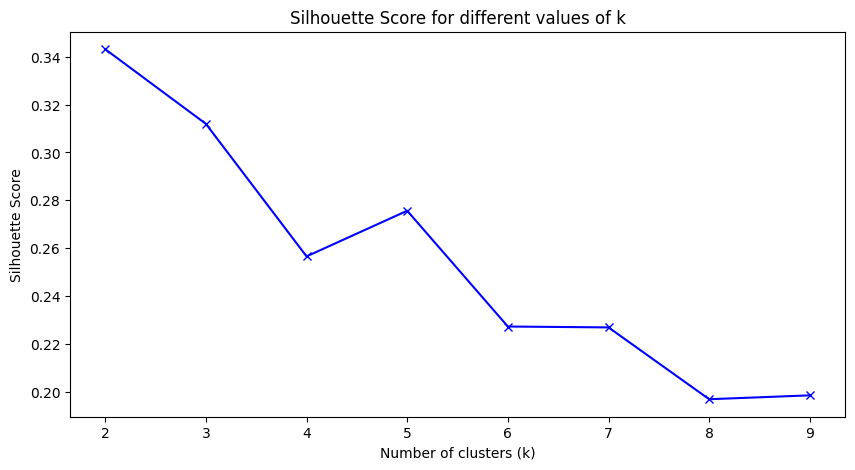

Optimal number of clusters: 2


In [ ]:
silhouette_scores = []
K = range(2, 10)

data_kmeans = train_data.drop(columns=['weather_delay_score_normalized', 'airport_delay_score_normalized', 'composite_delay_score_normalized', 'delay_category', 'airport_name'])

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_kmeans)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(data_kmeans, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

# Plotting Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k')
plt.show()

optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(data_kmeans)
print(f"Optimal number of clusters: {optimal_k}")

## Dynamic Random Forest

In [ ]:
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_train, y_train)

# Finding the importance of features
feature_importance = base_rf.feature_importances_

dynamic_weights = feature_importance / feature_importance.sum()
dynamic_weights = dynamic_weights.reshape(1, -1)

# Apply dynamic weights to feature values
X_train_weighted = X_train * dynamic_weights

dynamic_rf = RandomForestClassifier(random_state=42)
dynamic_rf.fit(X_train_weighted, y_train)

X_test_weighted = X_test * dynamic_weights
y_pred = dynamic_rf.predict(X_test_weighted)
accuracy = accuracy_score(y_test, y_pred)

y_pred_labels = target_encoder.inverse_transform(y_pred)

# k-fold cross-validation
cv_scores_new_target = cross_val_score(dynamic_rf, X_train_weighted, y_train, cv=5, scoring='accuracy')
mean_accuracy_new_target = np.mean(cv_scores_new_target)

In [ ]:
print("Accurracy: ", {accuracy})
print("Cross-Validation Scores: ", {tuple(cv_scores_new_target)})
print("Mean Accuracy: ", {mean_accuracy_new_target})

print("Random Forest Classification Report:")
y_test_labels = target_encoder.inverse_transform(y_test)
print(classification_report(y_test_labels, y_pred_labels))

Accurracy:  {0.8370807926829268}
Cross-Validation Scores:  {(0.8377128442295565, 0.8610468782846332, 0.8536892999789784, 0.8280428841706958, 0.8385197645079899)}
Mean Accuracy:  {0.8438023342343707}
Random Forest Classification Report:
                precision    recall  f1-score   support

    High Delay       0.85      0.87      0.86      3349
     Low Delay       0.90      0.87      0.89      3581
Moderate Delay       0.76      0.77      0.76      3566

      accuracy                           0.84     10496
     macro avg       0.84      0.84      0.84     10496
  weighted avg       0.84      0.84      0.84     10496



# Consolidated List of High Delay Airpots

In [ ]:
print("High Delay Airports predicted by SVM: ", len(high_delay_airports_svm.index.tolist()))
print("High Delay Airports predicted by Random Forest: ", len(high_delay_airports_rf.index.tolist()))
print("High Delay Airports predicted by Gradient Boosing: ", len(high_delay_airports_gb.index.tolist()))

high_delay_airports_set = set(high_delay_airports_svm.index.tolist()) & set(high_delay_airports_rf.index.tolist()) & set(high_delay_airports_gb.index.tolist())
print("\nConsolidated list of High Delay Airports: ", len(high_delay_airports_set))
high_delay_airports = pd.DataFrame(list(high_delay_airports_set), columns=["airport_name"])
high_delay_airports

High Delay Airports predicted by SVM:  115
High Delay Airports predicted by Random Forest:  113
High Delay Airports predicted by Gradient Boosing:  113

Consolidated list of High Delay Airports:  106


airport_name
0        Springfield, MO: Springfield-Branson National
1      Columbus, OH: John Glenn Columbus International
2        Phoenix, AZ: Phoenix Sky Harbor International
3              Lake Charles, LA: Lake Charles Regional
4                                Adak Island, AK: Adak
..                                                 ...
101  Wichita, KS: Wichita Dwight D Eisenhower National
102                           Lihue, HI: Lihue Airport
103    Lawton/Fort Sill, OK: Lawton-Fort Sill Regional
104  Baton Rouge, LA: Baton Rouge Metropolitan/Ryan...
105  New Bern/Morehead/Beaufort, NC: Coastal Caroli...

[106 rows x 1 columns]

# Airport Specific Recommendations

In [ ]:
reviews_data = pd.ExcelFile('/content/drive/MyDrive/Colab Notebooks/ML/filtered_airports_reviews.xlsx')
reviews_data_df = reviews_data.parse('Reviews')

high_delay_airports['airport_name'] = high_delay_airports['airport_name'].str.split(':').str[0].str.strip()
reviews_data_df['Airport Name'] = reviews_data_df['Airport Name'].str.strip()
high_delay_airports_set = set(high_delay_airports['airport_name'].unique())
reviews_airports = reviews_data_df['Airport Name'].unique()

airport_name_mapping = {}
for delay_airport in high_delay_airports_set:
    best_match = None
    highest_score = 0
    for review_airport in reviews_airports:
        score = fuzz.ratio(delay_airport.lower(), review_airport.lower())
        if score > highest_score:
            highest_score = score
            best_match = review_airport
    if highest_score >= 80:
        airport_name_mapping[delay_airport] = best_match

mapped_review_airports = list(airport_name_mapping.values())
filtered_reviews = reviews_data_df[reviews_data_df['Airport Name'].isin(mapped_review_airports)]
filtered_reviews['High_Delay_Airport_Name'] = filtered_reviews['Airport Name'].map(
    {v: k for k, v in airport_name_mapping.items()}
)

filtered_reviews['Sentiment'] = filtered_reviews['Content'].apply(
    lambda x: TextBlob(x).sentiment.polarity if pd.notnull(x) else None
)
negative_reviews = filtered_reviews[filtered_reviews['Sentiment'] < 0]['Content'].dropna()

tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_reviews)
negative_keywords_filtered = tfidf_vectorizer.get_feature_names_out()

refined_negative_keywords = {
    "staff": [kw for kw in negative_keywords_filtered if "staff" in kw or "rude" in kw or "unprofessional" in kw],
    "cleanliness": [kw for kw in negative_keywords_filtered if "dirty" in kw or "filthy" in kw],
    "queue": [kw for kw in negative_keywords_filtered if "wait" in kw or "line" in kw],
    "security": [kw for kw in negative_keywords_filtered if "security" in kw],
    "general_service": [kw for kw in negative_keywords_filtered if any(kw.startswith(term) for term in ["poor", "horrible", "worst", "bad"])],
    "infrastructure": [kw for kw in negative_keywords_filtered if any(kw in kw for kw in ["luggage", "facilities", "way", "walk"])]
}
for key in refined_negative_keywords:
    refined_negative_keywords[key] = list(set(refined_negative_keywords[key]))[:50]

def generate_combined_recommendations(row):
    recommendations = []

    if pd.notnull(row['Queuing Times']) and row['Queuing Times'] < 3:
        recommendations.append("Optimize queuing systems to reduce wait times")
    if pd.notnull(row['Terminal Cleanliness']) and row['Terminal Cleanliness'] < 3:
        recommendations.append("Enhance cleanliness standards")
    if pd.notnull(row['Terminal Seating']) and row['Terminal Seating'] < 3:
        recommendations.append("Add more seating options")
    if pd.notnull(row['Food Beverages']) and row['Food Beverages'] < 3:
        recommendations.append("Upgrade food and beverage options")
    if pd.notnull(row['Wifi Connectivity']) and row['Wifi Connectivity'] < 3:
        recommendations.append("Enhance WiFi connectivity")
    if pd.notnull(row['Airport Staff']) and row['Airport Staff'] < 3:
        recommendations.append("Improve staff training and behavior")

    if pd.notnull(row['Content']):
        content_lower = row['Content'].lower()
        for category, keywords in refined_negative_keywords.items():
            if any(keyword in content_lower for keyword in keywords):
                if category == "staff" and not any("staff" in item.lower() for item in recommendations):
                    recommendations.append("Improve staff behavior and training")
                elif category == "cleanliness" and not any("cleanliness" in item.lower() for item in recommendations):
                    recommendations.append("Enhance cleanliness standards")
                elif category == "queue" and not any("queuing" in item.lower() for item in recommendations):
                    recommendations.append("Optimize queuing systems to reduce wait times")
                elif category == "security":
                    recommendations.append("Improve security procedures and training")
                elif category == "general_service":
                    recommendations.append("Review overall service quality")
                elif category == "infrastructure":
                    recommendations.append("Upgrade airport infrastructure and facilities")

    return "; ".join(set(recommendations)) if recommendations else "Maintain standards"

filtered_reviews['Combined Recommendation'] = filtered_reviews.apply(generate_combined_recommendations, axis=1)

combined_airport_recommendations = filtered_reviews.groupby('High_Delay_Airport_Name')['Combined Recommendation'].apply(
    lambda x: ", ".join(set("; ".join(x).split("; ")))
).reset_index()

combined_recommendations_csv_path = 'airport_specific_recommendations.csv'
combined_airport_recommendations.to_csv(combined_recommendations_csv_path, index=False)

In [ ]:
recommendations = pd.read_csv('airport_specific_recommendations.csv')
recommendations

High_Delay_Airport_Name                            Combined Recommendation
0             Amarillo, TX                                 Maintain standards
1             Columbus, OH  Add more seating options, Upgrade airport infr...
2       Corpus Christi, TX  Upgrade food and beverage options, Improve sta...
3        Daytona Beach, FL  Upgrade food and beverage options, Add more se...
4           Des Moines, IA                                 Maintain standards
5      Fort Lauderdale, FL  Add more seating options, Upgrade airport infr...
6           Fort Myers, FL  Add more seating options, Review overall servi...
7             Honolulu, HI  Add more seating options, Upgrade airport infr...
8         Indianapolis, IN  Add more seating options, Upgrade airport infr...
9         Jacksonville, FL  Upgrade airport infrastructure and facilities,...
10         Kansas City, MO  Add more seating options, Upgrade airport infr...
11           Milwaukee, WI  Add more seating options, Upgrade airport infr...
12        Myrtle Beach, SC  Maintain standards, Optimize queuing systems t...
13           Nashville, TN  Add more seating options, Upgrade airport infr...
14         New Orleans, LA  Add more seating options, Upgrade airport infr...
15       Oklahoma City, OK                                 Maintain standards
16           Pensacola, FL  Maintain standards, Enhance WiFi connectivity,...
17        Philadelphia, PA  Add more seating options, Upgrade airport infr...
18         Punta Gorda, FL  Add more seating options, Enhance cleanliness ...
19            Richmond, VA  Add more seating options, Upgrade airport infr...
20          Sacramento, CA  Upgrade airport infrastructure and facilities,...
21      Salt Lake City, UT  Add more seating options, Upgrade airport infr...
22         San Antonio, TX  Add more seating options, Upgrade airport infr...
23           San Diego, CA  Add more seating options, Upgrade airport infr...
24       San Francisco, CA  Add more seating options, Upgrade airport infr...
25          Shreveport, LA  Upgrade food and beverage options, Optimize qu...